# 06 Preprocessing of Sentinel-1 SAR data

## <a name="quicklink">Quick link

* [Objective](#objective)
* [Data](#data)
* [Workflow](#workflow)
 * [Step 1: subset](#subset)
 * [Step 2: Calibration](#calibrate)
 * [Step 3: Post-processing - Geometric correction](#terrain)
* [License](#license)

## <a name="objective">Objective 

The objective of this module is to pre-process a Sentinel-1 over the Etna using SNAP.


## <a name="data">Data

SENTINEL data products are made available systematically and free of charge to all data users including the general public, scientific and commercial users. Radar data will be delivered within an hour of reception for Near Real-Time (NRT) emergency response, within three hours for NRT priority areas and within 24 hours for systematically archived data.

All data products are distributed in the SENTINEL Standard Archive Format for Europe (SAFE) format.

Sentinel-1 data products are available in single polarisation (VV or HH) for Wave mode and dual polarisation (VV+VH or HH+HV) and single polarisation (HH or VV) for SM, IW and EW modes.

Level-1 Ground Range Detected (GRD) products consist of focused SAR data that has been detected, multi-looked and projected to ground range using an Earth ellipsoid model. Phase information is lost. The resulting product has approximately square resolution pixels and square pixel spacing with reduced speckle at the cost of reduced geometric resolution.

GRD products can be in one of three resolutions:

* Full Resolution (FR)
* High Resolution (HR)
* Medium Resolution (MR).

The resolution is dependent upon the amount of multi-looking performed. Level-1 GRD products are available in MR and HR for IW and EW modes, MR for WV mode and MR, HR and FR for SM mode.

## <a name="workflow">Workflow

* Step 1: Subset

In [1]:
from snappy import jpy
from snappy import ProductIO
s1path = "S1A_IW_GRDH_1SDV_20161114T165602_20161114T165627_013941_016729_59B8"
s1meta = "manifest.safe"
s1prd = "/workspace/data/%s/%s.SAFE/%s" % (s1path, s1path, s1meta)
reader = ProductIO.getProductReader("SENTINEL-1")
product = reader.readProductNodes(s1prd, None)

In [2]:
import snappy
from snappy import GPF
from snappy import HashMap

HashMap = jpy.get_type('java.util.HashMap')    
GPF.getDefaultInstance().getOperatorSpiRegistry().loadOperatorSpis()

WKTReader = snappy.jpy.get_type('com.vividsolutions.jts.io.WKTReader')
 
lon_min = 14.702
lat_min = 37.584
lon_max = 15.353
lat_max = 37.953
  
pt1 = "%s %s" % (lon_min, lat_min)
pt2 = "%s %s" % (lon_max, lat_min)
pt3 = "%s %s" % (lon_max, lat_max)
pt4 = "%s %s" % (lon_min, lat_max)  
    
wkt = "POLYGON((%s, %s, %s, %s, %s))" % (pt1, pt2, pt3, pt4, pt1)
 
geom = WKTReader().read(wkt)
 
parameters = HashMap()
parameters.put('geoRegion', geom)
parameters.put('outputImageScaleInDb', False)
parameters.put('copyMetadata', True)
subset = GPF.createProduct('Subset', parameters, product)

* Step 2: Calibration

In [3]:
parameters = HashMap() 

polarization = "VV"

parameters.put('outputSigmaBand', True) 
parameters.put('sourceBands', 'Intensity_' + polarization) 
parameters.put('selectedPolarisations', polarization) 
parameters.put('outputImageScaleInDb', False)  

calibrate = GPF.createProduct('Calibration', parameters, subset)

* Step 3: Geometric correction

In [4]:
parameters = HashMap()

parameters.put('demResamplingMethod', 'NEAREST_NEIGHBOUR') 
parameters.put('imgResamplingMethod', 'NEAREST_NEIGHBOUR') 
parameters.put('demName', 'SRTM 3Sec') 
parameters.put('pixelSpacingInMeter', 10.0) 
parameters.put('sourceBands', 'Sigma0_' + polarization)

terrain = GPF.createProduct('Terrain-Correction', parameters, calibrate)

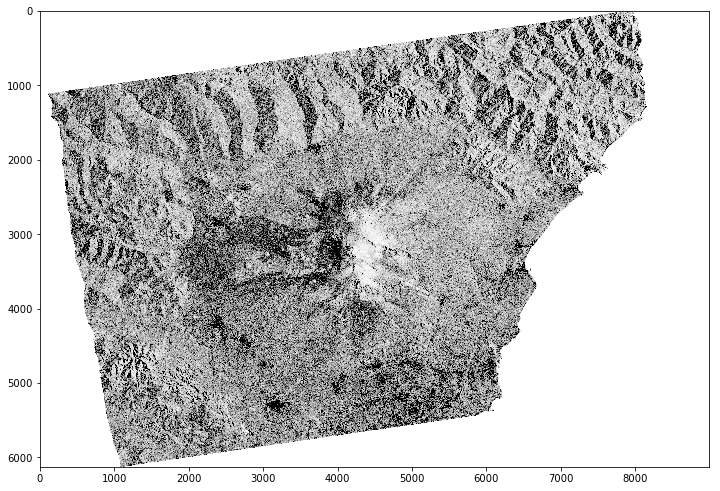

In [5]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors

%matplotlib inline

def plotBand(product, band, vmin, vmax):
     
    band = product.getBand(band)

    w = band.getRasterWidth()
    h = band.getRasterHeight()

    band_data = np.zeros(w * h, np.float32)
    band.readPixels(0, 0, w, h, band_data)

    band_data.shape = h, w

    width = 12
    height = 12
    plt.figure(figsize=(width, height))
    imgplot = plt.imshow(band_data, cmap=plt.cm.binary, vmin=vmin, vmax=vmax)
    
    return imgplot 

plotBand(terrain, 'Sigma0_' + polarization, 0, 0.3)

## <a name="license">License

This work is licenced under a [Attribution-ShareAlike 4.0 International License (CC BY-SA 4.0)](http://creativecommons.org/licenses/by-sa/4.0/) 

YOU ARE FREE TO:

* Share - copy and redistribute the material in any medium or format.
* Adapt - remix, transform, and built upon the material for any purpose, even commercially.

UNDER THE FOLLOWING TERMS:

* Attribution - You must give appropriate credit, provide a link to the license, and indicate if changes were made. You may do so in any reasonable manner, but not in any way that suggests the licensor endorses you or your use.
* ShareAlike - If you remix, transform, or build upon the material, you must distribute your contributions under the same license as the original.